In [2]:
!git clone https://github.com/huggingface/diffusers


fatal: destination path 'diffusers' already exists and is not an empty directory.


In [3]:
%cd diffusers


/content/diffusers


In [4]:
!pip install -e .

Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-0.editable-py3-none-any.whl size=11095 sha256=c2e6b648f7b90c13a0e0b6eab0c7ea43d54afc45a3411d66a4e12c0b258217cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-3yz54ryq/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.0.dev0
    Uninstalling diffusers-0.30.0.dev0:
      Successfully uninstalled diffusers-0.30.0.dev0


In [5]:
%cd examples


/content/diffusers/examples


In [6]:
%cd controlnet


/content/diffusers/examples/controlnet


In [7]:
!pip install -r requirements.txt


In [8]:
!pip install accelerate
from accelerate.utils import write_basic_config
write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [9]:

!wget https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet_training/conditioning_image_1.png
!wget https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet_training/conditioning_image_2.png


--2024-06-24 06:10:35--  https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet_training/conditioning_image_1.png
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.124, 18.172.134.88, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/huggingface/documentation-images/fe26d74518b1ba2f566e9971cf7e1eecb018090da2c2e0c87323cb60f54a8d51?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27conditioning_image_1.png%3B+filename%3D%22conditioning_image_1.png%22%3B&response-content-type=image%2Fpng&Expires=1719468635&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxOTQ2ODYzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYXRhc2V0cy9odWdnaW5nZmFjZS9kb2N1bWVudGF0aW9uLWltYWdlcy9mZTI2ZDc0NTE4YjFiYTJmNTY2ZTk5NzFjZjdlMWVlY2IwMTgwOTBkYTJjMmUwYzg3M

In [12]:
mkdir output_path

In [15]:
import os
os.environ['MODEL_DIR'] = 'runwayml/stable-diffusion-v1-5'
os.environ['OUTPUT_DIR'] = '/content/diffusers/examples/controlnet/output_path'



# Run the training script with accelerate
!accelerate launch diffusers/examples/controlnet/train_controlnet.py \
 --pretrained_model_name_or_path=$MODEL_DIR \
 --output_dir=$OUTPUT_DIR \
 --dataset_name=fusing/fill50k \
 --resolution=512 \
 --learning_rate=1e-5 \
 --validation_image "./conditioning_image_1.png" "./conditioning_image_2.png" \
 --validation_prompt "red circle with blue background" "cyan circle with brown floral background" \
 --train_batch_size=4

/usr/bin/python3: can't open file '/content/diffusers/examples/controlnet/diffusers/examples/controlnet/train_controlnet.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/accelerate/commands/accelerate_cli.py", line 48, in main
    args.func(args)
  File "/usr/local/lib/python3.10/dist-packages/accelerate/commands/launch.py", line 1097, in launch_command
    simple_launcher(args)
  File "/usr/local/lib/python3.10/dist-packages/accelerate/commands/launch.py", line 703, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
subprocess.CalledProcessError: Command '['/usr/bin/python3', 'diffusers/examples/controlnet/train_controlnet.py', '--pretrained_model_name_or_path=runwayml/stable-diffusion-v1-5', '--output_dir=/content/diffusers/examples/controlnet/output_path', '--dataset_name=fusing/fill50k

In [ ]:
mkdir savec


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch

base_model_path = "unwayml/stable-diffusion-v1-5"
controlnet_path = "/content/output_model"

controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed or when using Torch 2.0.
pipe.enable_xformers_memory_efficient_attention()
# memory optimization.
pipe.enable_model_cpu_offload()

control_image = load_image("./conditioning_image_1.png")
prompt = "pale golden rod circle with old lace background"

# generate image
generator = torch.manual_seed(0)
image = pipe(
    prompt, num_inference_steps=20, generator=generator, image=control_image
).images[0]
image.save("./output.png")

OSError: Error no file named config.json found in directory /content/output_model.

In [ ]:
!git clone https://github.com/lllyasviel/ControlNet.git

Cloning into 'ControlNet'...
remote: Enumerating objects: 1356, done.
remote: Total 1356 (delta 0), reused 0 (delta 0), pack-reused 1356
Receiving objects: 100% (1356/1356), 122.40 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (599/599), done.


In [ ]:
#give the openpose as the input image and check
#do not give any prompt and see
#check different ways to change the controlnet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ControlNet(nn.Module):
    def __init__(self, input_dim, control_dim, hidden_dim):
        super(ControlNet, self).__init__()
        self.fc1 = nn.Linear(input_dim + control_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x, control):
        x = torch.cat((x, control), dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class StableDiffusionModel(nn.Module):
    def __init__(self, image_size, noise_dim, control_dim, hidden_dim):
        super(StableDiffusionModel, self).__init__()
        self.image_size = image_size
        self.noise_dim = noise_dim
        self.control_dim = control_dim
        self.hidden_dim = hidden_dim

        self.control_net = ControlNet(noise_dim, control_dim, hidden_dim)

        self.fc1 = nn.Linear(noise_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, image_size * image_size * 3)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, noise, control):
        noise = self.control_net(noise, control)
        x = self.relu(self.fc1(noise))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, 3, self.image_size, self.image_size)
        return x

# Hyperparameters
image_size = 64
noise_dim = 100
control_dim = 10
hidden_dim = 256
batch_size = 32
learning_rate = 0.0002

# Initialize model, loss function, and optimizer
model = StableDiffusionModel(image_size, noise_dim, control_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Example training loop
num_epochs = 1000
for epoch in range(num_epochs):
    noise = torch.randn(batch_size, noise_dim)
    control = torch.randn(batch_size, control_dim)
    fake_images = model(noise, control)

    # Assume target_images is a batch of real images
    target_images = torch.randn(batch_size, 3, image_size, image_size)

    loss = criterion(fake_images, target_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/1000], Loss: 1.0032
Epoch [100/1000], Loss: 1.0013
Epoch [200/1000], Loss: 0.9966
Epoch [300/1000], Loss: 1.0008
Epoch [400/1000], Loss: 0.9961
Epoch [500/1000], Loss: 1.0008
Epoch [600/1000], Loss: 0.9973
Epoch [700/1000], Loss: 0.9993
Epoch [800/1000], Loss: 0.9998
Epoch [900/1000], Loss: 1.0044


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import BertModel, BertTokenizer
from PIL import Image

class TextEncoder(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased'):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

class ImageEncoder(nn.Module):
    def __init__(self, input_channels=3, output_dim=512):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, output_dim, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x

class ControlNet(nn.Module):
    def __init__(self, input_dim, control_dim, hidden_dim):
        super(ControlNet, self).__init__()
        self.fc1 = nn.Linear(input_dim + control_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x, control):
        x = torch.cat((x, control), dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class StableDiffusionModel(nn.Module):
    def __init__(self, image_size, noise_dim, control_dim, hidden_dim):
        super(StableDiffusionModel, self).__init__()
        self.image_size = image_size
        self.noise_dim = noise_dim
        self.control_dim = control_dim
        self.hidden_dim = hidden_dim

        self.control_net = ControlNet(noise_dim, control_dim, hidden_dim)

        self.fc1 = nn.Linear(noise_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, image_size * image_size * 3)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, noise, control):
        noise = self.control_net(noise, control)
        x = self.relu(self.fc1(noise))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, 3, self.image_size, self.image_size)
        return x

# Hyperparameters
image_size = 64
noise_dim = 100
text_dim = 768  # BERT base hidden size
image_feature_dim = image_size // 16 * image_size // 16 * 512  # Output dimension from ImageEncoder
control_dim = text_dim + image_feature_dim
hidden_dim = 512
batch_size = 32
learning_rate = 0.0002

# Initialize models, tokenizer, loss function, and optimizer
text_encoder = TextEncoder()
image_encoder = ImageEncoder()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = StableDiffusionModel(image_size, noise_dim, control_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(text_encoder.parameters()) + list(image_encoder.parameters()) + list(model.parameters()), lr=learning_rate)

# Example text and image input
text_input = ["A beautiful landscape with mountains and a river"]
inputs = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Load and preprocess input image
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

input_image = Image.open('person.png')  # Replace with your image path
input_image = transform(input_image).unsqueeze(0)

# Example training loop
num_epochs = 1000
for epoch in range(num_epochs):
    noise = torch.randn(batch_size, noise_dim)

    text_features = text_encoder(input_ids, attention_mask).repeat(batch_size, 1)  # Repeat for batch
    image_features = image_encoder(input_image).repeat(batch_size, 1)  # Repeat for batch

    control = torch.cat((text_features, image_features), dim=-1)

    fake_images = model(noise, control)

    # Assume target_images is a batch of real images
    target_images = torch.randn(batch_size, 3, image_size, image_size)

    loss = criterion(fake_images, target_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        # Display generated image

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

        generated_image = fake_images[0].detach().cpu()

        # Denormalize the image from [-1, 1] to [0, 1]
        generated_image = (generated_image + 1) / 2

        # Convert to PIL Image
        generated_image = transforms.ToPILImage()(generated_image)

        # Display the image
        plt.imshow(generated_image)
        plt.axis('off')
        plt.show()


Epoch [0/1000], Loss: 1.0000
Epoch [100/1000], Loss: 1.0028
Epoch [200/1000], Loss: 1.0032
Epoch [300/1000], Loss: 1.0006
Epoch [400/1000], Loss: 0.9965
Epoch [500/1000], Loss: 0.9970
Epoch [600/1000], Loss: 1.0022
Epoch [700/1000], Loss: 0.9969


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import BertModel, BertTokenizer
from PIL import Image

class TextEncoder(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased'):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

class ImageEncoder(nn.Module):
    def __init__(self, input_channels=3, output_dim=512):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, output_dim, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x

class ControlNet(nn.Module):
    def __init__(self, input_dim, control_dim, hidden_dim):
        super(ControlNet, self).__init__()
        self.fc1 = nn.Linear(input_dim + control_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x, control):
        x = torch.cat((x, control), dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class StableDiffusionModel(nn.Module):
    def __init__(self, image_size, noise_dim, control_dim, hidden_dim):
        super(StableDiffusionModel, self).__init__()
        self.image_size = image_size
        self.noise_dim = noise_dim
        self.control_dim = control_dim
        self.hidden_dim = hidden_dim

        self.control_net = ControlNet(noise_dim, control_dim, hidden_dim)

        self.fc1 = nn.Linear(noise_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, image_size * image_size * 3)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, noise, control):
        noise = self.control_net(noise, control)
        x = self.relu(self.fc1(noise))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, 3, self.image_size, self.image_size)
        return x

# Hyperparameters
image_size = 64
noise_dim = 100
text_dim = 768  # BERT base hidden size
image_feature_dim = image_size // 16 * image_size // 16 * 512  # Output dimension from ImageEncoder
control_dim = text_dim + image_feature_dim
hidden_dim = 512
batch_size = 1
learning_rate = 0.0002

# Initialize models, tokenizer, loss function, and optimizer
text_encoder = TextEncoder()
image_encoder = ImageEncoder()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = StableDiffusionModel(image_size, noise_dim, control_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(text_encoder.parameters()) + list(image_encoder.parameters()) + list(model.parameters()), lr=learning_rate)

# Example text and image input
text_input = ["A beautiful landscape with mountains and a river"]
inputs = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Load and preprocess input image
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

input_image = Image.open('person.png')
input_image = Image.resize((64,64))  # Replace with your image path
input_image = transform(input_image).unsqueeze(0)

# Check dimensions
print(f"Input image shape: {input_image.shape}")  # Should be (1, 3, 64, 64)

# Example training loop
num_epochs = 1000
for epoch in range(num_epochs):
    noise = torch.randn(batch_size, noise_dim)

    text_features = text_encoder(input_ids, attention_mask).repeat(batch_size, 1)  # Repeat for batch
    image_features = image_encoder(input_image).repeat(batch_size, 1)  # Repeat for batch

    print(f"Text features shape: {text_features.shape}")  # Should be (batch_size, 768)
    print(f"Image features shape: {image_features.shape}")  # Should be (batch_size, 8192)

    control = torch.cat((text_features, image_features), dim=-1)

    fake_images = model(noise, control)

    # Assume target_images is a batch of real images
    target_images = torch.randn(batch_size, 3, image_size, image_size)

    loss = criterion(fake_images, target_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Input image shape: torch.Size([1, 3, 64, 64])
Epoch [0/1000], Loss: 0.9921


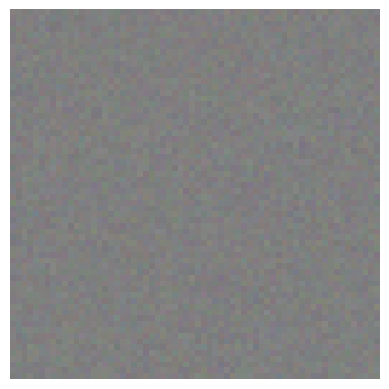

Epoch [100/1000], Loss: 1.0177


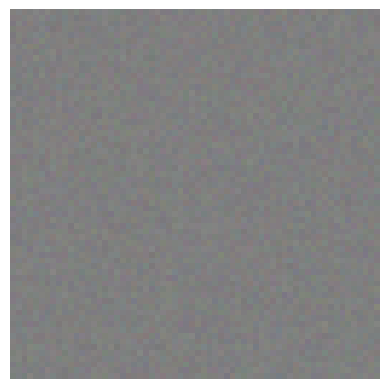

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import BertModel, BertTokenizer
from PIL import Image
import matplotlib.pyplot as plt

class TextEncoder(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased'):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

class ImageEncoder(nn.Module):
    def __init__(self, input_channels=3, output_dim=512):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, output_dim, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x

class ControlNet(nn.Module):
    def __init__(self, input_dim, control_dim, hidden_dim):
        super(ControlNet, self).__init__()
        self.fc1 = nn.Linear(input_dim + control_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x, control):
        x = torch.cat((x, control), dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class StableDiffusionModel(nn.Module):
    def __init__(self, image_size, noise_dim, control_dim, hidden_dim):
        super(StableDiffusionModel, self).__init__()
        self.image_size = image_size
        self.noise_dim = noise_dim
        self.control_dim = control_dim
        self.hidden_dim = hidden_dim

        self.control_net = ControlNet(noise_dim, control_dim, hidden_dim)

        self.fc1 = nn.Linear(noise_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, image_size * image_size * 3)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, noise, control):
        noise = self.control_net(noise, control)
        x = self.relu(self.fc1(noise))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, 3, self.image_size, self.image_size)
        return x

# Hyperparameters
image_size = 64
noise_dim = 100
text_dim = 768  # BERT base hidden size
image_feature_dim = image_size // 16 * image_size // 16 * 512  # Output dimension from ImageEncoder
control_dim = text_dim + image_feature_dim
hidden_dim = 512
batch_size = 1
learning_rate = 0.0002

# Initialize models, tokenizer, loss function, and optimizer
text_encoder = TextEncoder()
image_encoder = ImageEncoder()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = StableDiffusionModel(image_size, noise_dim, control_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(text_encoder.parameters()) + list(image_encoder.parameters()) + list(model.parameters()), lr=learning_rate)

# Example text and image input
text_input = ["A beautiful landscape with mountains and a river"]
inputs = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Load and preprocess input image
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

input_image = Image.open('person.png')
#input_image = input_image.resize((64,64)) # Replace with your image path
input_image = transform(input_image).unsqueeze(0)

# Check dimensions
print(f"Input image shape: {input_image.shape}")  # Should be (1, 3, 64, 64)

# Example training loop
num_epochs = 1000
for epoch in range(num_epochs):
    noise = torch.randn(batch_size, noise_dim)

    text_features = text_encoder(input_ids, attention_mask).repeat(batch_size, 1)  # Repeat for batch
    image_features = image_encoder(input_image).repeat(batch_size, 1)  # Repeat for batch

    #print(f"Text features shape: {text_features.shape}")  # Should be (batch_size, 768)
    #print(f"Image features shape: {image_features.shape}")  # Should be (batch_size, 8192)

    control = torch.cat((text_features, image_features), dim=-1)

    fake_images = model(noise, control)

    # Assume target_images is a batch of real images
    target_images = torch.randn(batch_size, 3, image_size, image_size)

    loss = criterion(fake_images, target_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

        # Display generated image
        generated_image = fake_images[0].detach().cpu()

        # Denormalize the image from [-1, 1] to [0, 1]
        generated_image = (generated_image + 1) / 2

        # Convert to PIL Image
        generated_image = transforms.ToPILImage()(generated_image)

        # Display the image
        plt.imshow(generated_image)
        plt.axis('off')
        plt.show()


In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, features * 2)
        self.encoder3 = UNet._block(features * 2, features * 4)
        self.encoder4 = UNet._block(features * 4, features * 8)

        self.bottleneck = UNet._block(features * 8, features * 16)

        self.decoder4 = UNet._block(features * 16, features * 8)
        self.decoder3 = UNet._block(features * 8, features * 4)
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.decoder1 = UNet._block(features * 2, features)

        self.final_layer = nn.Conv2d(features, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.tanh(self.final_layer(dec1))

    @staticmethod
    def _block(in_channels, features, name=""):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True)
        )


In [ ]:
class StableDiffusionModel(nn.Module):
    def __init__(self, image_size, noise_dim, control_dim, hidden_dim):
        super(StableDiffusionModel, self).__init__()
        self.image_size = image_size
        self.noise_dim = noise_dim
        self.control_dim = control_dim
        self.hidden_dim = hidden_dim

        self.control_net = ControlNet(noise_dim, control_dim, hidden_dim)

        self.unet = UNet(in_channels=3, out_channels=3)

    def forward(self, noise, control):
        # Combine noise and control vectors using ControlNet
        noise = self.control_net(noise, control)

        # Reshape noise to image size
        noise = noise.view(-1, 3, self.image_size, self.image_size)

        # Pass through the UNet for denoising
        denoised_image = self.unet(noise)

        return denoised_image


In [ ]:
# Hyperparameters
image_size = 64
noise_dim = 100
text_dim = 768  # BERT base hidden size
image_feature_dim = image_size // 16 * image_size // 16 * 512  # Output dimension from ImageEncoder
control_dim = text_dim + image_feature_dim
hidden_dim = 512
batch_size = 1
learning_rate = 0.0002

# Initialize models, tokenizer, loss function, and optimizer
text_encoder = TextEncoder()
image_encoder = ImageEncoder()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = StableDiffusionModel(image_size, noise_dim, control_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(text_encoder.parameters()) + list(image_encoder.parameters()) + list(model.parameters()), lr=learning_rate)

# Example text and image input
text_input = ["A beautiful landscape with mountains and a river"]
inputs = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Load and preprocess input image
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

input_image = Image.open('person.png')
input_image = transform(input_image).unsqueeze(0)

# Check dimensions
print(f"Input image shape: {input_image.shape}")  # Should be (1, 3, 64, 64)

# Example training loop
num_epochs = 1000
for epoch in range(num_epochs):
    noise = torch.randn(batch_size, noise_dim)

    text_features = text_encoder(input_ids, attention_mask).repeat(batch_size, 1)  # Repeat for batch
    image_features = image_encoder(input_image).repeat(batch_size, 1)  # Repeat for batch

    control = torch.cat((text_features, image_features), dim=-1)

    fake_images = model(noise, control)

    # Assume target_images is a batch of real images
    target_images = torch.randn(batch_size, 3, image_size, image_size)

    loss = criterion(fake_images, target_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

        # Display generated image
        generated_image = fake_images[0].detach().cpu()

        # Denormalize the image from [-1, 1] to [0, 1]
        generated_image = (generated_image + 1) / 2

        # Convert to PIL Image
        generated_image = transforms.ToPILImage()(generated_image)

        # Display the image
        plt.imshow(generated_image)
        plt.axis('off')
        plt.show()
